In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

**Načteme dataset Fashion MNIST**

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 1s 0us/step


In [4]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [5]:
K = keras.backend

In [6]:
codings_size = 10

tf.random.set_seed(42)
np.random.seed(42)

**Encoder**

In [7]:
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

**Decoder**

In [8]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

**Model jako celek**

In [9]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

**Ztrátová funkce**

máme zde dvě ztrátové funkce
- binary_crossentropy, která se snaží, aby rekonstrukce vypadala stejně jako vstupní data
- latent_loss, která se snaží, aby kódování (latentní reprezentace) vypadaly, jako by pocházely z Gaussova (normálního) rozdělení

In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

In [11]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 6s 10ms/step - loss: 0.3894 - rounded_accuracy: 0.8610 - val_loss: 0.3533 - val_rounded_accuracy: 0.8844
Epoch 2/25
430/430 [==============================] - 4s 8ms/step - loss: 0.3424 - rounded_accuracy: 0.8980 - val_loss: 0.3348 - val_rounded_accuracy: 0.9058
Epoch 3/25
430/430 [==============================] - 4s 10ms/step - loss: 0.3327 - rounded_accuracy: 0.9054 - val_loss: 0.3299 - val_rounded_accuracy: 0.9097
Epoch 4/25
430/430 [==============================] - 3s 8ms/step - loss: 0.3279 - rounded_accuracy: 0.9091 - val_loss: 0.3300 - val_rounded_accuracy: 0.9096
Epoch 5/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3248 - rounded_accuracy: 0.9118 - val_loss: 0.3271 - val_rounded_accuracy: 0.9135
Epoch 6/25
430/430 [==============================] - 5s 11ms/step - loss: 0.3226 - rounded_accuracy: 0.9138 - val_loss: 0.3259 - val_rounded_accuracy: 0.9128
Epoch 7/25
430/430 [=============================

In [12]:
import matplotlib.pyplot as plt

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [13]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

**Vygenerujeme úplně nové obrázky tím, že si z latentního prostoru zvolíme libovolné body**

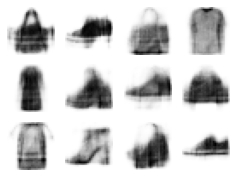

In [14]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

**Zkusíme sémantickou interpolaci**

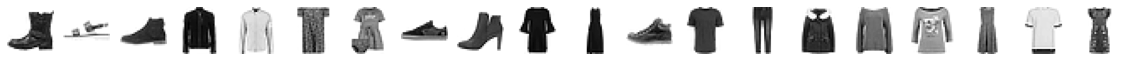

In [25]:
plot_multiple_images(X_valid[60:80])

In [31]:
x1 = 72
x2 = 75

**Nyní získáme codings pro tyto dva obrázky a pak je budeme interpolovat**

In [32]:
_, _, coding1 = variational_encoder.predict(X_valid[x1:x1+1])
_, _, coding2 = variational_encoder.predict(X_valid[x2:x2+2])

coding1[0], coding2[0]

(array([-0.4154107 ,  1.8090922 , -0.8378639 ,  1.22685   ,  0.6497809 ,
        -0.14448673, -1.0472094 , -0.09139128, -0.45849556,  1.241471  ],
       dtype=float32),
 array([-0.05611894,  0.14693022, -1.0073882 ,  1.4524261 , -0.87593865,
        -0.14917374, -0.17268188,  0.92702675, -0.8063105 ,  1.0775568 ],
       dtype=float32))

In [33]:
interpolated_coding = (coding1[0] + coding2[0]) / 2
interpolated_coding

array([-0.23576482,  0.9780112 , -0.9226261 ,  1.339638  , -0.11307886,
       -0.14683023, -0.60994565,  0.41781774, -0.632403  ,  1.159514  ],
      dtype=float32)

In [34]:
new_image = variational_decoder(interpolated_coding.reshape(1,-1)).numpy()

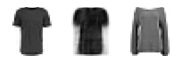

In [35]:
plot_multiple_images(np.array([X_valid[x1], new_image[0], X_valid[x2]]))

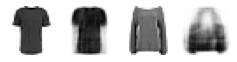

In [36]:
bigger_coding = (coding2[0] + (coding2[0]-coding1[0]))
bigger_image = variational_decoder(bigger_coding.reshape(1,-1)).numpy()
plot_multiple_images(np.array([X_valid[x1], new_image[0], X_valid[x2], bigger_image[0]]))